In this project we are trying to build a SSVM model for part-of- speech tagging in text data.

To begin with, let's import only one sentence file and play with it. Our first goal is trying to calculate its loss and gradient.

In [1]:
import os

datapath = 'data/';
files = os.listdir(datapath)
s = 50;   # to load file number 50:
fh = open(datapath+files[s],'r');
rawlines = fh.readlines();
lines = [line.strip('\n').split(',') for line in rawlines];
fh.close();
ys = [int(l[1])-1 for l in lines];
xs = [[int(l[2])-1,int(l[3]),int(l[4]),int(l[5])-1,int(l[6])-1] for l in lines];

In [2]:
# Initialize necessary variables
import numpy as np
import pyGM as gm
N = 0
nt = 0.01
Hamming_Loss = 0
Hinge_Loss = 0
feature_sizes = [1,2,2,201,201]
ThetaF = [.001*np.random.rand(10,feature_sizes[f]) for f in range(len(feature_sizes))]; 
ThetaP = .001*np.random.rand(10,10);
Loss = 1.0 - np.eye(10);  # hamming loss
ns = len(ys)
# Define random variables for the inference process:
Y = [gm.Var(i,10) for i in range(ns)];

Then we need to build a pridction model. All parameters have been initiated in the matrixes ThetaF and ThetaP. Also yhat and ypred can be easily found by junctiontree function.

In [3]:
# Build "prediction model" using your parameters
factors=[gm.Factor([Y[i],Y[i+1]],1.0) for i in range(ns-1)]
for f in factors:
    f.table = np.exp(ThetaP)
for i in range(ns):
    for j in range(len(feature_sizes)):
        factor = gm.Factor(Y[i], 1)
        factor.table = np.exp(ThetaF[j][:,xs[i][j]])
        factors.append(factor)

In [4]:
import pyGM.wmb
# so exponentiate the factors before making a model... 
model_pred = gm.GraphModel(factors);
# Copy factors and add extra Hamming factors for loss-augmented model
factors_aug = [ f for f in factors ]
factors_aug.extend( [gm.Factor([Y[i]], Loss[:,ys[i]]).exp() for i in range(ns)] ); 
model_aug = gm.GraphModel(factors_aug);

order = range(ns);  # eliminate in sequence (Markov chain on y)
wt = 1e-4;         # for max elimination in JTree implementation

# Now, the most likely configuration of the prediction model (for prediction) is:
yhat_pred = gm.wmb.JTree(model_pred,order,wt).argmax();
# and the maximizing argument of the loss (for computing the gradient) is
yhat_aug = gm.wmb.JTree(model_aug,order,wt).argmax();

The next step is calculate the feature function u, which is the score of the permutation of y.

In [5]:
ypred = list(yhat_pred.values())
yhat = list(yhat_aug.values())
h_loss = Loss[ypred, ys].sum()
Hamming_Loss += h_loss

In [6]:
u_ypred = 0
for i in range(ns):
    if i != ns-1:
        u_ypred += ThetaP[ypred[i]][ypred[i+1]]
    for j in range(len(feature_sizes)):
        u_ypred += ThetaF[j][ypred[i]][xs[i][j]]

In [7]:
u_ys = 0
for i in range(ns):
    if i != ns-1:
        u_ys += ThetaP[ys[i]][ys[i+1]]
    for j in range(len(feature_sizes)):
        u_ys += ThetaF[j][ys[i]][xs[i][j]]

The value of feature function is quite reasonable. The value of ys' feature function should be no greater than that of ypred's feature function.

In [8]:
u_ypred

0.065173994864121218

In [9]:
u_ys

0.050951620491576248

Last but not least, we can work on the calculation of gradient and update all of the parameters

In [10]:
from numpy import linalg
norms = [linalg.norm(ThetaF[i]) for i in range(len(feature_sizes))]
norms.append(linalg.norm(ThetaP))
norms = np.asarray(norms)
Hinge_Loss += h_loss + u_ypred - u_ys + nt*np.sum(norms*norms)

In [11]:
Hinge_Loss

14.014236576843304

In [12]:
N += ns
GradP = np.zeros((10, 10))
GradF = [np.zeros((10,feature_sizes[f])) for f in range(len(feature_sizes))];

In [13]:
for i in range(ns):
    for j in range(len(feature_sizes)):
        GradF[j][yhat[i],xs[i][j]] += 1
        GradF[j][ys[i],xs[i][j]] -= 1
    if i<ns-1:
        GradP[yhat[i],yhat[i+1]] += 1
        GradP[ys[i],ys[i+1]] -= 1

In [14]:
GradF = [nt*ThetaF[i] + GradF[i] for i in range(len(ThetaF))]
GradP = nt*ThetaP + GradP

ThetaF = [ThetaF[i] - GradF[i]/ns for i in range(len(ThetaF))]
ThetaP = ThetaP - (1/ns)*GradP

Done! We succesfully handled one of the sentence files. Now we can make an iteration on all of the sentence files and see how our algorithm performs!

Due to the huge number of files, we only go through one iteration just to check the performance of our algorithm.

In [15]:
import pyGM as gm
import pyGM.wmb
import numpy as np
import os
from numpy import linalg

datapath = 'data/';
files = os.listdir(datapath)
feature_sizes = [1,2,2,201,201]
ThetaF = [.001*np.random.rand(10,feature_sizes[f]) for f in range(len(feature_sizes))]; 
ThetaP = .001*np.random.rand(10,10);
Loss = 1.0 - np.eye(10);  # hamming loss
step = 0.1
reg = 0.01
num_iter = 1
HinLs = []
HamLs = []
# step size, etc.
for iter in range(num_iter):
    num = 0
    correct = 0
    N = 0
    Hamming_Loss = 0
    Hinge_Loss = 0
    for s in np.random.permutation(len(files)-1):
        num+=1
        if(num%100 == 0):
            accuracy = 1-Hamming_Loss/N
            avg_HinL = Hinge_Loss/num
            avg_HamL = Hamming_Loss/num
            HinLs.append(avg_HinL)
            HamLs.append(avg_HamL)
        if(num%1000 == 0):
            print('Reading '+str(num)+'th sentence.')
            print("Iter: {} Accuracy: {}".format(iter+1, accuracy))
            print("Average Hinge Loss: {} Average Hamming Loss: {}".format(avg_HinL, avg_HamL))
        # Load data ys,xs
        fh = open(datapath+files[s+1],'r');
        rawlines = fh.readlines();
        lines = [line.strip('\n').split(',') for line in rawlines];
        fh.close();
        ys = [int(l[1])-1 for l in lines];
        xs = [[int(l[2])-1,int(l[3]),int(l[4]),int(l[5])-1,int(l[6])-1] for l in lines];
        ns = len(ys)
        N += ns
        # Define random variables for the inference process:
        Y = [gm.Var(i,10) for i in range(ns)];

        # Build "prediction model" using your parameters
        factors=[gm.Factor([Y[i],Y[i+1]],1.0) for i in range(ns-1)]
        for f in factors:
            f.table = np.exp(ThetaP)
        for i in range(ns):
            for j in range(len(feature_sizes)):
                factor = gm.Factor(Y[i], 1)
                factor.table = np.exp(ThetaF[j][:,xs[i][j]])
                factors.append(factor)
        
        # don't forget pyGM expects models to be products of factors, 
        # so exponentiate the factors before making a model... 
        model_pred = gm.GraphModel(factors);
        # Copy factors and add extra Hamming factors for loss-augmented model
        factors_aug = [ f for f in factors ]
        factors_aug.extend( [gm.Factor([Y[i]], Loss[:,ys[i]]).exp() for i in range(ns)] ); 
        model_aug = gm.GraphModel(factors_aug);

        order = range(ns);  # eliminate in sequence (Markov chain on y)
        wt = 1e-4;         # for max elimination in JTree implementation

        # Now, the most likely configuration of the prediction model (for prediction) is:
        yhat_pred = gm.wmb.JTree(model_pred,order,wt).argmax();
        # and the maximizing argument of the loss (for computing the gradient) is
        yhat_aug = gm.wmb.JTree(model_aug,order,wt).argmax();

        # use yhat_pred & ys to keep a running estimate of your prediction accuracy & printit
        ypred = list(yhat_pred.values())
        yhat = list(yhat_aug.values())
        h_loss = Loss[ypred, ys].sum()
        Hamming_Loss += h_loss
        # calculating feature function
        u_ypred = 0
        for i in range(ns):
            if i != ns-1:
                u_ypred += ThetaP[ypred[i]][ypred[i+1]]
            for j in range(len(feature_sizes)):
                u_ypred += ThetaF[j][ypred[i]][xs[i][j]]
        u_ys = 0
        for i in range(ns):
            if i != ns-1:
                u_ys += ThetaP[ys[i]][ys[i+1]]
            for j in range(len(feature_sizes)):
                u_ys += ThetaF[j][ys[i]][xs[i][j]]
                
        # calculating Hinge Loss
        norms = [linalg.norm(ThetaF[i]) for i in range(len(feature_sizes))]
        norms.append(linalg.norm(ThetaP))
        norms = np.asarray(norms)
        Hinge_Loss += Loss[ypred, ys].sum() + u_ypred - u_ys + reg*np.dot(norms, norms)
        # how often etc is up to you
        # use yhat_aug & ys to update your parameters theta in the negative gradient direction
        GradP = np.zeros((10, 10))
        GradF = [np.zeros((10,feature_sizes[f])) for f in range(len(feature_sizes))];
        for i in range(ns):
            for j in range(len(feature_sizes)):
                GradF[j][yhat[i],xs[i][j]] += 1
                GradF[j][ys[i],xs[i][j]] -= 1
            if i<ns-1:
                GradP[yhat[i],yhat[i+1]] += 1
                GradP[ys[i],ys[i+1]] -= 1
        GradF = [reg*ThetaF[i] + GradF[i] for i in range(len(ThetaF))]
        GradP = reg*ThetaP + GradP
        ThetaF = [ThetaF[i] - step*GradF[i]/ns for i in range(len(ThetaF))]
        ThetaP = ThetaP - step*(1/ns)*GradP

Reading 1000th sentence.
Iter: 1 Accuracy: 0.7588936244237627
Average Hinge Loss: 7.197256453910526 Average Hamming Loss: 5.544
Reading 2000th sentence.
Iter: 1 Accuracy: 0.7926091586794463
Average Hinge Loss: 6.830015123644105 Average Hamming Loss: 4.8685
Reading 3000th sentence.
Iter: 1 Accuracy: 0.8080422950447896
Average Hinge Loss: 6.675682171007223 Average Hamming Loss: 4.514333333333333
Reading 4000th sentence.
Iter: 1 Accuracy: 0.8176956217237208
Average Hinge Loss: 6.604635788033613 Average Hamming Loss: 4.295
Reading 5000th sentence.
Iter: 1 Accuracy: 0.8246810102263744
Average Hinge Loss: 6.542542413335591 Average Hamming Loss: 4.1248
Reading 6000th sentence.
Iter: 1 Accuracy: 0.8296297874455831
Average Hinge Loss: 6.510535461860795 Average Hamming Loss: 3.9983333333333335


Last but not least, show the beautiful graph of Hinge loss and Hamming loss we've got during the SGD! We can see it is monotonically decreasing :)

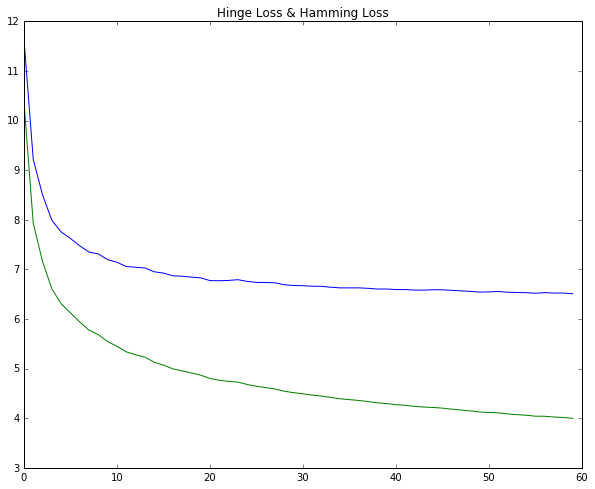

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# a magic to inline matplot
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.plot([i for i in range(len(HinLs))], HinLs)
plt.plot([i for i in range(len(HamLs))], HamLs)
plt.title('Hinge Loss & Hamming Loss')
plt.show()

In [17]:
import numpy as np
A = np.array([[1/3, 2/3,0,0,0,0,0], [1/4, 3/4,0,0,0,0,0], [0,0,0,2/3,1/3,0,0], [0,0,1,0,0,0,0], [0,0,1,0,0,0,0],
             [1/6,0,1/6,1/6,0,1/4,1/4], [0,0,0,0,0,0,1]])

In [26]:
A = A.dot(A)
print (A)

[[  2.72727273e-001   7.27272727e-001   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  2.72727273e-001   7.27272727e-001   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.66666667e-001
    3.33333333e-001   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.66666667e-001
    3.33333333e-001   0.00000000e+000   0.00000000e+000]
 [  6.06060606e-002   1.61616162e-001   2.22222222e-001   1.48148148e-001
    7.40740741e-002   7.45834073e-155   3.33333333e-001]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   1.00000000e+000]]


In [29]:
A = A.dot(np.array([[1/3, 2/3,0,0,0,0,0], [1/4, 3/4,0,0,0,0,0], [0,0,0,2/3,1/3,0,0], [0,0,1,0,0,0,0], [0,0,1,0,0,0,0],
             [1/6,0,1/6,1/6,0,1/4,1/4], [0,0,0,0,0,0,1]]))
print (A)

[[  2.72727273e-001   7.27272727e-001   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  2.72727273e-001   7.27272727e-001   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   6.66666667e-001
    3.33333333e-001   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   1.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  6.06060606e-002   1.61616162e-001   2.22222222e-001   1.48148148e-001
    7.40740741e-002   1.16536574e-156   3.33333333e-001]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
    0.00000000e+000   0.00000000e+000   1.00000000e+000]]
